# 🦟 Dengue Outbreak Analytics & Forecasting — Starter Notebook
**Goal:** Learn the full pipeline (data → features → forecast → risk index → map) using sample India-like data.  
Run cells in order. After you are comfortable, we'll replace the sample files with real NCVBDC / data.gov.in CSVs.


In [2]:

import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn xgboost folium requests


Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Imports and create folders
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Create folder structure
os.makedirs('project_folder/data_raw', exist_ok=True)
os.makedirs('project_folder/data_processed', exist_ok=True)
os.makedirs('project_folder/figures', exist_ok=True)
os.makedirs('project_folder/notebooks', exist_ok=True)

print("Folders created under project_folder/")


Folders created under project_folder/


In [4]:
# This creates synthetic weekly dengue + climate data for 3 districts (India-like behavior)
dates = pd.date_range(start='2019-01-07', end='2021-12-27', freq='W-MON')  # weekly Mondays
districts = ['Patna','Purnia','Nalanda']

# Dengue sample
rows = []
np.random.seed(42)
for d in districts:
    pop = {'Patna':2500000,'Purnia':1500000,'Nalanda':1200000}[d]
    base = {'Patna':50,'Purnia':30,'Nalanda':20}[d]
    for i, dt in enumerate(dates):
        woy = dt.isocalendar().week
        seasonal = 10 + 20*np.sin(2*np.pi*(woy/52))         # seasonal effect
        extra = 5*np.sin(2*np.pi*i/26)                     # semi-seasonal noise
        lam = max(0.5, base + seasonal + extra)
        cases = np.random.poisson(lam)
        rows.append({'date':dt, 'state':'Bihar', 'district':d, 'weekly_cases':int(cases), 'population':pop})
dengue_sample = pd.DataFrame(rows)
dengue_sample.to_csv('project_folder/data_raw/dengue_sample.csv', index=False)

# Climate sample (weekly aggregates)
rows = []
for d in districts:
    for dt in dates:
        woy = dt.isocalendar().week
        temp = 25 + 5*np.sin(2*np.pi*(woy/52)) + np.random.normal(0,1)
        rain = max(0, 50 + 80*np.sin(2*np.pi*(woy/52 + 0.1)) + np.random.normal(0,10))
        hum  = 65 + 10*np.sin(2*np.pi*(woy/52 - 0.2)) + np.random.normal(0,5)
        rows.append({'date':dt,'district':d,'t2m_mean':round(temp,2),'rain_mm':round(rain,2),'rh_mean':round(hum,2)})
climate_sample = pd.DataFrame(rows)
climate_sample.to_csv('project_folder/data_raw/climate_sample.csv', index=False)

print("Sample files saved to project_folder/data_raw/:", os.listdir('project_folder/data_raw') )


Sample files saved to project_folder/data_raw/: ['climate_sample.csv', 'dengue_sample.csv']


In [5]:
# Fix & recreate sample data (run this once)
import os
import numpy as np
import pandas as pd

# show where Jupyter is running from
print("Current working directory:", os.getcwd())

# create required folders (safe: won't error if they already exist)
os.makedirs('project_folder/data_raw', exist_ok=True)
os.makedirs('project_folder/data_processed', exist_ok=True)
os.makedirs('project_folder/figures', exist_ok=True)
os.makedirs('project_folder/notebooks', exist_ok=True)

print("project_folder contents now:", os.listdir('project_folder'))

# --- recreate sample dengue + climate data and save to CSVs ---
dates = pd.date_range(start='2019-01-07', end='2021-12-27', freq='W-MON')  # weekly Mondays
districts = ['Patna','Purnia','Nalanda']

# Dengue sample
rows = []
np.random.seed(42)
for d in districts:
    pop = {'Patna':2500000,'Purnia':1500000,'Nalanda':1200000}[d]
    base = {'Patna':50,'Purnia':30,'Nalanda':20}[d]
    for i, dt in enumerate(dates):
        woy = dt.isocalendar().week
        seasonal = 10 + 20*np.sin(2*np.pi*(woy/52))
        extra = 5*np.sin(2*np.pi*i/26)
        lam = max(0.5, base + seasonal + extra)
        cases = np.random.poisson(lam)
        rows.append({'date':dt, 'state':'Bihar', 'district':d, 'weekly_cases':int(cases), 'population':pop})
dengue_sample = pd.DataFrame(rows)
dengue_path = 'project_folder/data_raw/dengue_sample.csv'
dengue_sample.to_csv(dengue_path, index=False)

# Climate sample (weekly aggregates)
rows = []
for d in districts:
    for dt in dates:
        woy = dt.isocalendar().week
        temp = 25 + 5*np.sin(2*np.pi*(woy/52)) + np.random.normal(0,1)
        rain = max(0, 50 + 80*np.sin(2*np.pi*(woy/52 + 0.1)) + np.random.normal(0,10))
        hum  = 65 + 10*np.sin(2*np.pi*(woy/52 - 0.2)) + np.random.normal(0,5)
        rows.append({'date':dt,'district':d,'t2m_mean':round(temp,2),'rain_mm':round(rain,2),'rh_mean':round(hum,2)})
climate_sample = pd.DataFrame(rows)
climate_path = 'project_folder/data_raw/climate_sample.csv'
climate_sample.to_csv(climate_path, index=False)

print("Saved sample files:")
print(" -", dengue_path)
print(" -", climate_path)
print("\nFiles in project_folder/data_raw:", os.listdir('project_folder/data_raw'))

# quick preview (first 3 rows each)
print("\nDengue sample preview:")
print(dengue_sample.head(3).to_string(index=False))
print("\nClimate sample preview:")
print(climate_sample.head(3).to_string(index=False))


Current working directory: C:\Users\sapna
project_folder contents now: ['data_processed', 'data_raw', 'figures', 'notebooks']
Saved sample files:
 - project_folder/data_raw/dengue_sample.csv
 - project_folder/data_raw/climate_sample.csv

Files in project_folder/data_raw: ['climate_sample.csv', 'dengue_sample.csv']

Dengue sample preview:
      date state district  weekly_cases  population
2019-01-07 Bihar    Patna            62     2500000
2019-01-14 Bihar    Patna            74     2500000
2019-01-21 Bihar    Patna            62     2500000

Climate sample preview:
      date district  t2m_mean  rain_mm  rh_mean
2019-01-07    Patna     27.27   100.88    57.17
2019-01-14    Patna     26.07   128.87    49.59
2019-01-21    Patna     26.76   125.49    65.84


In [6]:
# STEP 2: Load & Inspect the Raw Data

import pandas as pd

# Load the datasets we saved in Step 1
dengue = pd.read_csv("project_folder/data_raw/dengue_sample.csv")
climate = pd.read_csv("project_folder/data_raw/climate_sample.csv")

print("Dengue dataset shape:", dengue.shape)
print("Climate dataset shape:", climate.shape)

print("\n--- Dengue preview ---")
display(dengue.head())

print("\n--- Climate preview ---")
display(climate.head())



Dengue dataset shape: (468, 5)
Climate dataset shape: (468, 5)

--- Dengue preview ---


,date,state,district,weekly_cases,population
0,2019-01-07,Bihar,Patna,62,2500000
1,2019-01-14,Bihar,Patna,74,2500000
2,2019-01-21,Bihar,Patna,62,2500000
3,2019-01-28,Bihar,Patna,77,2500000
4,2019-02-04,Bihar,Patna,87,2500000



--- Climate preview ---


,date,district,t2m_mean,rain_mm,rh_mean
0,2019-01-07,Patna,27.27,100.88,57.17
1,2019-01-14,Patna,26.07,128.87,49.59
2,2019-01-21,Patna,26.76,125.49,65.84
3,2019-01-28,Patna,27.77,119.91,68.33
4,2019-02-04,Patna,26.87,106.13,62.13


In [7]:
# STEP 3: Data Cleaning & Merging

# Convert date columns
dengue['date'] = pd.to_datetime(dengue['date'])
climate['date'] = pd.to_datetime(climate['date'])

# Merge datasets
merged = pd.merge(dengue, climate, on=['date','district'], how='inner')

# Save processed file
processed_path = "project_folder/data_processed/dengue_climate_merged.csv"
merged.to_csv(processed_path, index=False)

print("Merged dataset shape:", merged.shape)
print("Saved processed file at:", processed_path)

print("\n--- Merged Data Preview ---")
display(merged.head())


Merged dataset shape: (468, 8)
Saved processed file at: project_folder/data_processed/dengue_climate_merged.csv

--- Merged Data Preview ---


,date,state,district,weekly_cases,population,t2m_mean,rain_mm,rh_mean
0,2019-01-07,Bihar,Patna,62,2500000,27.27,100.88,57.17
1,2019-01-14,Bihar,Patna,74,2500000,26.07,128.87,49.59
2,2019-01-21,Bihar,Patna,62,2500000,26.76,125.49,65.84
3,2019-01-28,Bihar,Patna,77,2500000,27.77,119.91,68.33
4,2019-02-04,Bihar,Patna,87,2500000,26.87,106.13,62.13


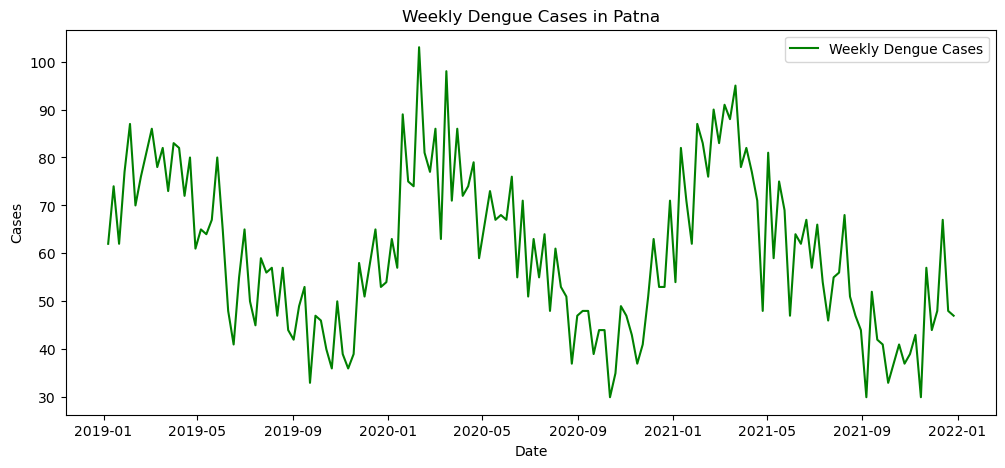

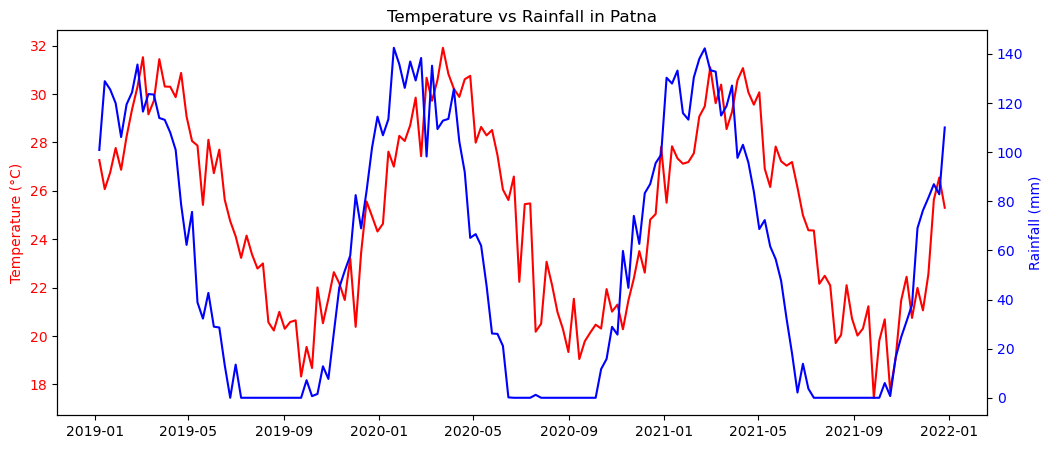

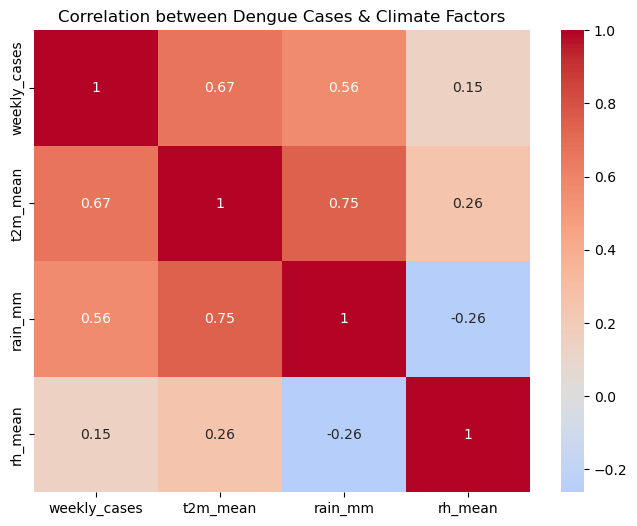

In [8]:
# -------------------------------------------------------------
# STEP 4: Exploratory Data Analysis (EDA)
# -------------------------------------------------------------
# Goal: Explore the merged dataset to understand how dengue cases
#       relate to climate factors before forecasting.
# What we will do:
#   1) Plot weekly dengue cases trend for a district (Patna)
#   2) Visualize temperature & rainfall over time
#   3) Check correlations between dengue and climate variables
# -------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# 1) Dengue trend over time (Patna)
plt.figure(figsize=(12,5))
subset = merged[merged['district']=='Patna']
plt.plot(subset['date'], subset['weekly_cases'], label='Weekly Dengue Cases', color='green')
plt.title("Weekly Dengue Cases in Patna")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.show()

# 2) Climate trends (Temperature vs Rainfall in Patna)
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(subset['date'], subset['t2m_mean'], color='red', label='Temperature (°C)')
ax1.set_ylabel("Temperature (°C)", color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(subset['date'], subset['rain_mm'], color='blue', label='Rainfall (mm)')
ax2.set_ylabel("Rainfall (mm)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title("Temperature vs Rainfall in Patna")
plt.show()

# 3) Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(merged[['weekly_cases','t2m_mean','rain_mm','rh_mean']].corr(),
            annot=True, cmap='coolwarm', center=0)
plt.title("Correlation between Dengue Cases & Climate Factors")
plt.show()


In [9]:
# -------------------------------------------------------------
# STEP 5: Feature Engineering
# -------------------------------------------------------------

# Sort by date to ensure correct time sequence
merged = merged.sort_values(by="date")

# Create lag features for dengue cases (previous 1 and 2 weeks)
merged['cases_lag1'] = merged['weekly_cases'].shift(1)
merged['cases_lag2'] = merged['weekly_cases'].shift(2)

# Create rolling average features for climate variables (last 2 weeks)
merged['temp_roll2'] = merged['t2m_mean'].rolling(window=2).mean()
merged['rain_roll2'] = merged['rain_mm'].rolling(window=2).mean()
merged['rh_roll2']   = merged['rh_mean'].rolling(window=2).mean()

# Drop rows with NaN values caused by lag/rolling
merged = merged.dropna().reset_index(drop=True)

print("\nData after feature engineering (first 5 rows):")
print(merged.head())



Data after feature engineering (first 5 rows):
        date  state district  weekly_cases  population  t2m_mean  rain_mm  \
0 2019-01-07  Bihar   Purnia            34     1500000     26.23   103.61   
1 2019-01-14  Bihar    Patna            74     2500000     26.07   128.87   
2 2019-01-14  Bihar  Nalanda            33     1200000     27.03   115.57   
3 2019-01-14  Bihar   Purnia            35     1500000     26.10   137.05   
4 2019-01-21  Bihar    Patna            62     2500000     26.76   125.49   

   rh_mean  cases_lag1  cases_lag2  temp_roll2  rain_roll2  rh_roll2  
0    58.81        39.0        62.0      26.910     106.125    58.380  
1    49.59        34.0        39.0      26.150     116.240    54.200  
2    61.26        74.0        34.0      26.550     122.220    55.425  
3    57.89        33.0        74.0      26.565     126.310    59.575  
4    65.84        35.0        33.0      26.430     131.270    61.865  


In [10]:
# -------------------------------------------------------------
# STEP 6: Train-Test Split & Baseline Modeling
# -------------------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Features (X) and Target (y)
X = merged[['t2m_mean', 'rain_mm', 'rh_mean',
            'cases_lag1', 'cases_lag2',
            'temp_roll2', 'rain_roll2', 'rh_roll2']]
y = merged['weekly_cases']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # no shuffle because time-series
)

# Baseline Model: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print("📊 Baseline Model Results (Linear Regression)")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


📊 Baseline Model Results (Linear Regression)
Mean Squared Error: 232.18
R² Score: 0.04


In [11]:
# -------------------------------------------------------------
# STEP 7: Improved Model with Lag Features & Random Forest
# -------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create lag features (previous weeks' dengue cases)
for lag in range(1, 5):  # last 4 weeks
    merged[f'dengue_lag_{lag}'] = merged['weekly_cases'].shift(lag)

# Drop rows with NaN (caused by lagging)
merged = merged.dropna()

# Features: climate + lagged dengue
X = merged[['t2m_mean', 'rain_mm', 'rh_mean', 
            'dengue_lag_1', 'dengue_lag_2', 'dengue_lag_3', 'dengue_lag_4']]
y = merged['weekly_cases']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Random Forest model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Improved Model Results (Random Forest)")
print("Mean Squared Error:", round(mse, 2))
print("R² Score:", round(r2, 2))


Improved Model Results (Random Forest)
Mean Squared Error: 235.61
R² Score: 0.04


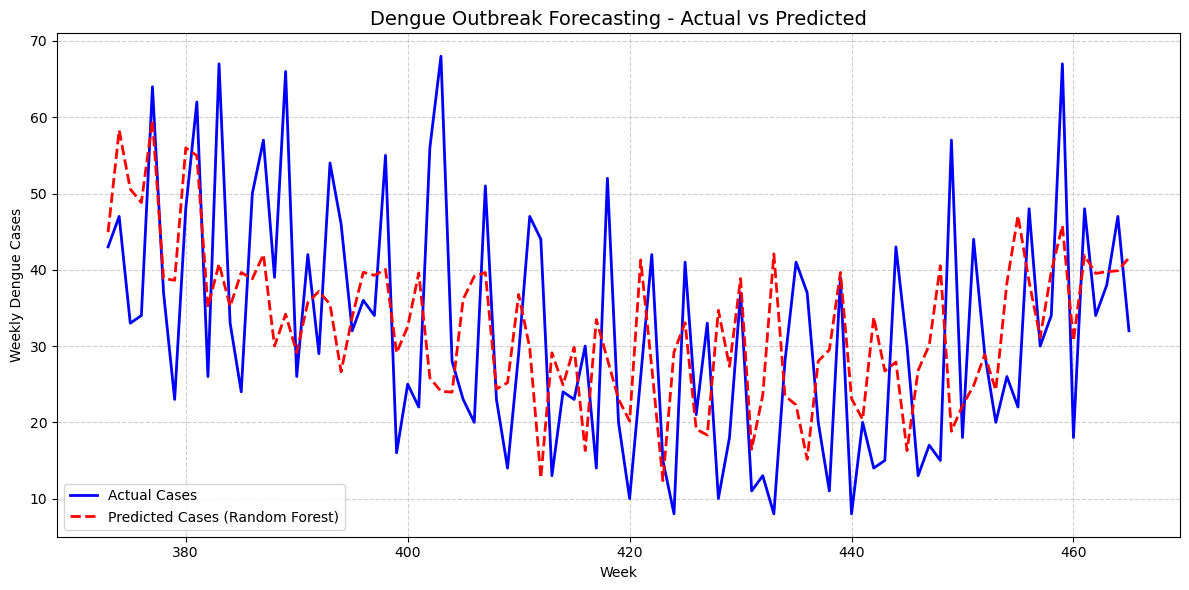

In [12]:
# -------------------------------------------------------------
# STEP 8: Visualization - Actual vs Predicted Dengue Cases
# -------------------------------------------------------------
plt.figure(figsize=(12,6))

# Plot actual
plt.plot(y_test.index, y_test.values, label="Actual Cases", color="blue", linewidth=2)

# Plot predicted
plt.plot(y_test.index, y_pred, label="Predicted Cases (Random Forest)", color="red", linestyle="--", linewidth=2)

plt.title("Dengue Outbreak Forecasting - Actual vs Predicted", fontsize=14)
plt.xlabel("Week")
plt.ylabel("Weekly Dengue Cases")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Save figure in project folder
plt.savefig("project_folder/figures/dengue_forecast_plot.png")
plt.show()


In [13]:
pip install geopandas


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [12]:
import os

print("Files in data_processed:", os.listdir("project_folder/data_processed"))


Files in data_processed: ['dengue_climate_merged.csv']


Columns in dataset: Index(['date', 'state', 'district', 'weekly_cases', 'population', 't2m_mean',
       'rain_mm', 'rh_mean'],
      dtype='object')
District-level summary saved at: project_folder/data_processed/district_summary.csv


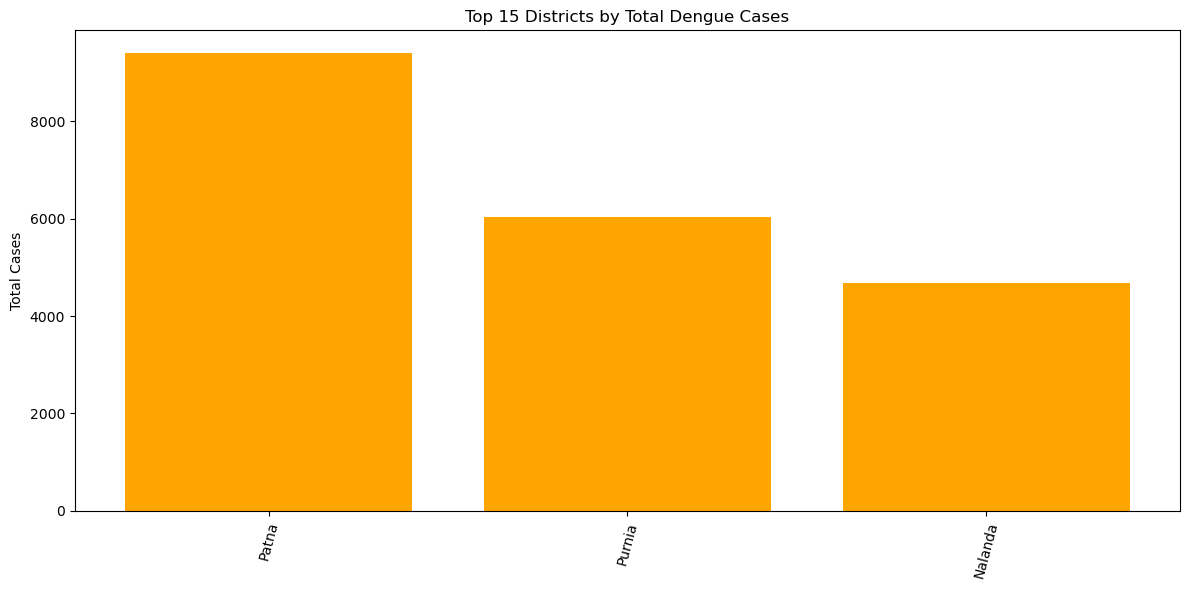

In [14]:

# STEP 9: District-Level Analysis
# -------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load merged dataset (your actual file)
merged_path = "project_folder/data_processed/dengue_climate_merged.csv"
merged = pd.read_csv(merged_path)

# 2. Check available columns
print("Columns in dataset:", merged.columns)

# 3. Make sure we have a 'district' column (adjust name if different)
if "district" not in merged.columns:
    # Sometimes column names differ like 'District', 'DISTRICT', etc.
    merged.rename(columns={col: "district" for col in merged.columns if col.lower() == "district"}, inplace=True)

# 4. Total cases by district
district_summary = merged.groupby("district")["weekly_cases"].sum().reset_index()
district_summary = district_summary.sort_values(by="weekly_cases", ascending=False)

# 5. Save to CSV
district_summary.to_csv("project_folder/data_processed/district_summary.csv", index=False)
print("District-level summary saved at: project_folder/data_processed/district_summary.csv")

# 6. Bar chart of top 15 districts
plt.figure(figsize=(12,6))
plt.bar(district_summary["district"].head(15), district_summary["weekly_cases"].head(15), color="orange")
plt.xticks(rotation=75)
plt.title("Top 15 Districts by Total Dengue Cases")
plt.ylabel("Total Cases")
plt.tight_layout()
plt.savefig("project_folder/figures/top_districts.png")
plt.show()


In [18]:
import os

print("Files in maps-master:", os.listdir("project_folder/data_raw/maps-master"))


Files in maps-master: ['assembly-constituencies', 'Country', 'Districts', 'divisions', 'docs', 'eci', 'LICENSE', 'parliamentary-constituencies', 'README.md', 'States', 'Survey-of-India-Index-Maps', 'website']


In [20]:
import glob

shp_files = glob.glob("project_folder/data_raw/maps-master/**/*.shp", recursive=True)
print("Shapefiles found:", shp_files)


Shapefiles found: ['project_folder/data_raw/maps-master\\assembly-constituencies\\India_AC.shp', 'project_folder/data_raw/maps-master\\Districts\\Census_2001\\2001_Dist.shp', 'project_folder/data_raw/maps-master\\Districts\\Census_2011\\2011_Dist.shp', 'project_folder/data_raw/maps-master\\eci\\AC_Data\\States\\S01\\S01_AC.shp', 'project_folder/data_raw/maps-master\\eci\\AC_Data\\States\\S02\\S02_AC.shp', 'project_folder/data_raw/maps-master\\eci\\AC_Data\\States\\S03\\S03_AC.shp', 'project_folder/data_raw/maps-master\\eci\\AC_Data\\States\\S04\\S04_AC.shp', 'project_folder/data_raw/maps-master\\eci\\AC_Data\\States\\S05\\S05_AC.shp', 'project_folder/data_raw/maps-master\\eci\\AC_Data\\States\\S06\\S06_AC.shp', 'project_folder/data_raw/maps-master\\eci\\AC_Data\\States\\S07\\S07_AC.shp', 'project_folder/data_raw/maps-master\\eci\\AC_Data\\States\\S08\\S08_AC.shp', 'project_folder/data_raw/maps-master\\eci\\AC_Data\\States\\S09\\S09_AC.shp', 'project_folder/data_raw/maps-master\\eci\\AC

In [22]:
shapefile_path = "project_folder/data_raw/maps-master/State/Districts/india_districts.shp"


In [26]:
import os

for root, dirs, files in os.walk("project_folder/data_raw/maps-master"):
    print("📂 Folder:", root)
    for f in files:
        print("   -", f)


📂 Folder: project_folder/data_raw/maps-master
   - LICENSE
   - README.md
📂 Folder: project_folder/data_raw/maps-master\assembly-constituencies
   - India_AC.dbf
   - India_AC.prj
   - India_AC.shp
   - India_AC.shp.xml
   - India_AC.shx
   - README.md
📂 Folder: project_folder/data_raw/maps-master\Country
   - india-composite.geojson
   - india-land-simplified.geojson
   - india-osm.geojson
   - india-soi.geojson
   - README.md
📂 Folder: project_folder/data_raw/maps-master\Country\disputed
   - india-disputed-lsib.geojson
   - pok-alhasan.geojson
   - pok-districts-alhasan.geojson
   - shaksgam-ne.geojson
📂 Folder: project_folder/data_raw/maps-master\Districts
   - README.md
📂 Folder: project_folder/data_raw/maps-master\Districts\Census_2001
   - 2001_Dist.dbf
   - 2001_Dist.prj
   - 2001_Dist.sbn
   - 2001_Dist.sbx
   - 2001_Dist.shp
   - 2001_Dist.shp.xml
   - 2001_Dist.shx
📂 Folder: project_folder/data_raw/maps-master\Districts\Census_2011
   - 2011_Dist.dbf
   - 2011_Dist.prj
   - 

     DISTRICT           ST_NM  ST_CEN_CD  DT_CEN_CD  censuscode  \
0    Adilabad  Andhra Pradesh         28          1         532   
1        Agra   Uttar Pradesh          9         15         146   
2   Ahmadabad         Gujarat         24          7         474   
3  Ahmadnagar     Maharashtra         27         26         522   
4      Aizawl         Mizoram         15          3         283   

                                            geometry  
0  POLYGON ((78.84972 19.7601, 78.85102 19.75945,...  
1  POLYGON ((78.19803 27.4028, 78.19804 27.40278,...  
2  MULTIPOLYGON (((72.03456 23.50527, 72.03337 23...  
3  POLYGON ((74.67333 19.9467, 74.67393 19.93509,...  
4  POLYGON ((92.98749 24.40453, 92.99107 24.40236...  


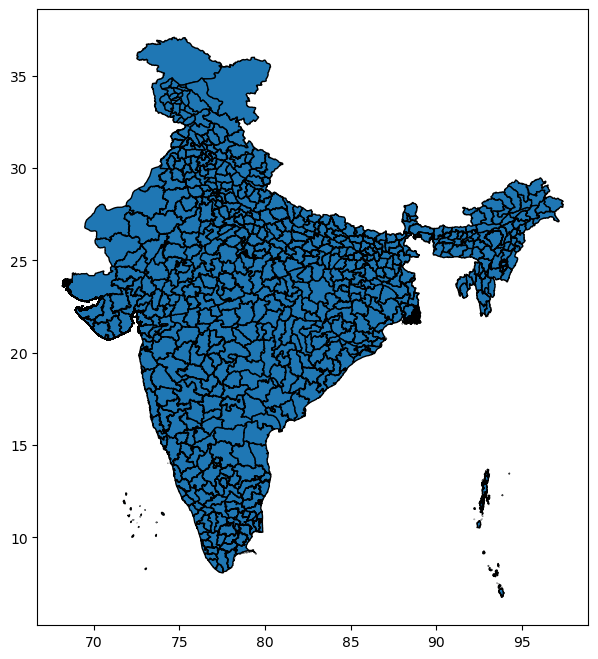

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Path to district shapefile
shp_path = "project_folder/data_raw/maps-master/Districts/Census_2011/2011_Dist.shp"

# Load using geopandas
districts = gpd.read_file(shp_path)

# Quick info
print(districts.head())

# Plot the map
districts.plot(figsize=(10, 8), edgecolor="black")
plt.show()


In [5]:
print(districts.columns)
print(dengue_data.columns)


Index(['DISTRICT', 'ST_NM', 'ST_CEN_CD', 'DT_CEN_CD', 'censuscode',
       'geometry'],
      dtype='object')
Index(['date', 'state', 'district', 'weekly_cases', 'population', 't2m_mean',
       'rain_mm', 'rh_mean'],
      dtype='object')


In [8]:
print("Shapefile columns:\n", districts.columns.tolist())
print("Dengue data columns:\n", dengue_data.columns.tolist())


Shapefile columns:
 ['DISTRICT', 'ST_NM', 'ST_CEN_CD', 'DT_CEN_CD', 'censuscode', 'geometry']
Dengue data columns:
 ['date', 'state', 'district', 'weekly_cases', 'population', 't2m_mean', 'rain_mm', 'rh_mean']


✅ Merge completed. Districts matched: 3


<Figure size 1200x800 with 0 Axes>

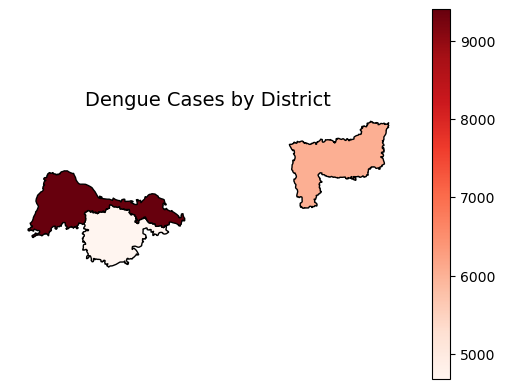

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# 1. Load shapefile and dengue dataset
shp_path = "project_folder/data_raw/maps-master/Districts/Census_2011/2011_Dist.shp"
districts = gpd.read_file(shp_path)
dengue_data = pd.read_csv("project_folder/data_processed/dengue_climate_merged.csv")

# 2. Standardize district names
districts["DISTRICT"] = districts["DISTRICT"].str.lower().str.strip()
dengue_data["district"] = dengue_data["district"].str.lower().str.strip()

# 3. Aggregate dengue cases by district (since dengue_data may have multiple rows per district)
dengue_summary = dengue_data.groupby("district")["weekly_cases"].sum().reset_index()

# 4. Merge shapefile with dengue summary
merged = districts.merge(
    dengue_summary,
    left_on="DISTRICT",
    right_on="district",
    how="inner"
)

print("✅ Merge completed. Districts matched:", len(merged))

# 5. Plot dengue cases on map
plt.figure(figsize=(12,8))
merged.plot(
    column="weekly_cases",
    cmap="Reds",
    legend=True,
    edgecolor="black"
)
plt.title("Dengue Cases by District", fontsize=14)
plt.axis("off")
plt.show()


In [12]:
# Save merged dataset
output_path = "project_folder/data_processed/dengue_districts_merged.csv"
merged.to_csv(output_path, index=False)

print(f"✅ Merged dataset saved at: {output_path}")


✅ Merged dataset saved at: project_folder/data_processed/dengue_districts_merged.csv


In [14]:
# Get top 10 districts by total cases
top10 = merged.sort_values("weekly_cases", ascending=False).head(10)
print("🔥 Top 10 Dengue Hotspot Districts:")
print(top10[["DISTRICT", "weekly_cases"]])


🔥 Top 10 Dengue Hotspot Districts:
  DISTRICT  weekly_cases
1    patna          9398
2   purnia          6028
0  nalanda          4683


<Figure size 1200x800 with 0 Axes>

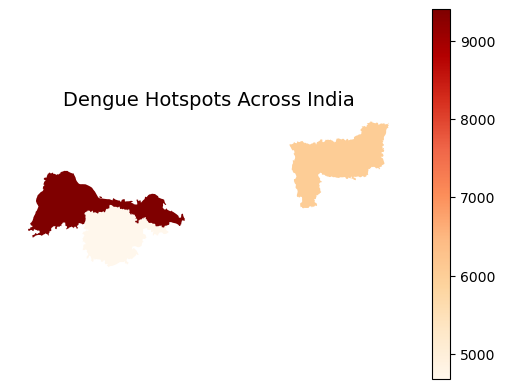

In [16]:
# Heatmap view
plt.figure(figsize=(12,8))
merged.plot(
    column="weekly_cases",
    cmap="OrRd",   # Orange-Red colormap for hotspots
    legend=True,
    edgecolor="none"
)
plt.title("Dengue Hotspots Across India", fontsize=14)
plt.axis("off")
plt.show()


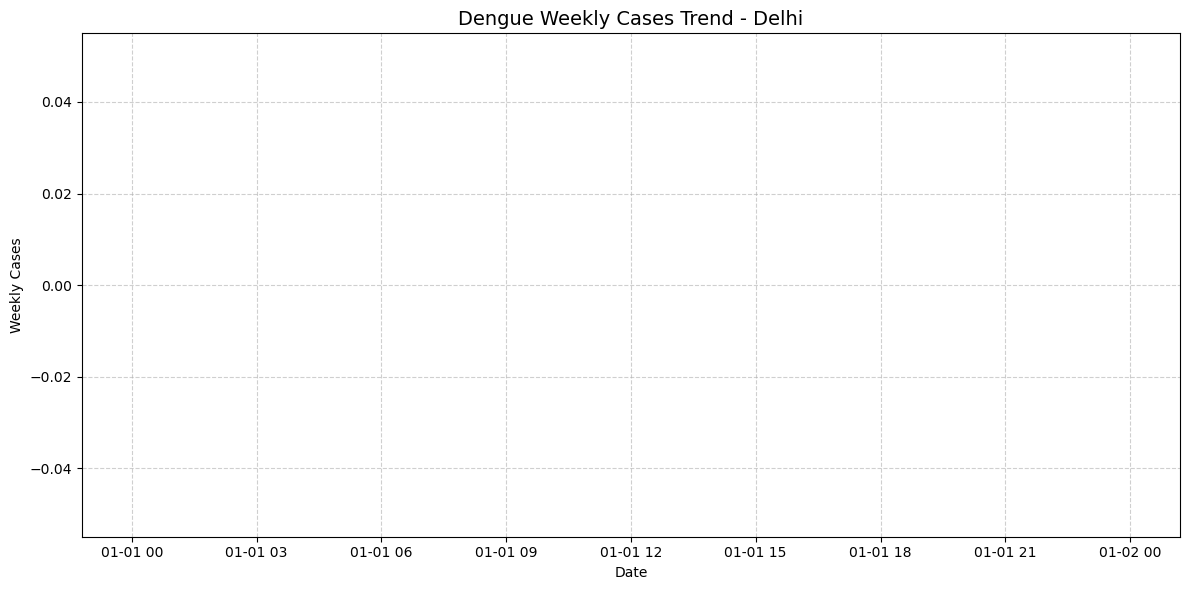

In [20]:
# Example: choose Delhi
district_name = "Delhi"

# Filter data for district (case-insensitive match)
district_data = dengue_data[dengue_data["district"].str.lower() == district_name.lower()]

# Convert date column to datetime
district_data["date"] = pd.to_datetime(district_data["date"])

# Plot
plt.figure(figsize=(12,6))
plt.plot(district_data["date"], district_data["weekly_cases"], marker="o", color="blue")
plt.title(f"Dengue Weekly Cases Trend - {district_name}", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Weekly Cases")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



📌 Forecasting for: patna


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


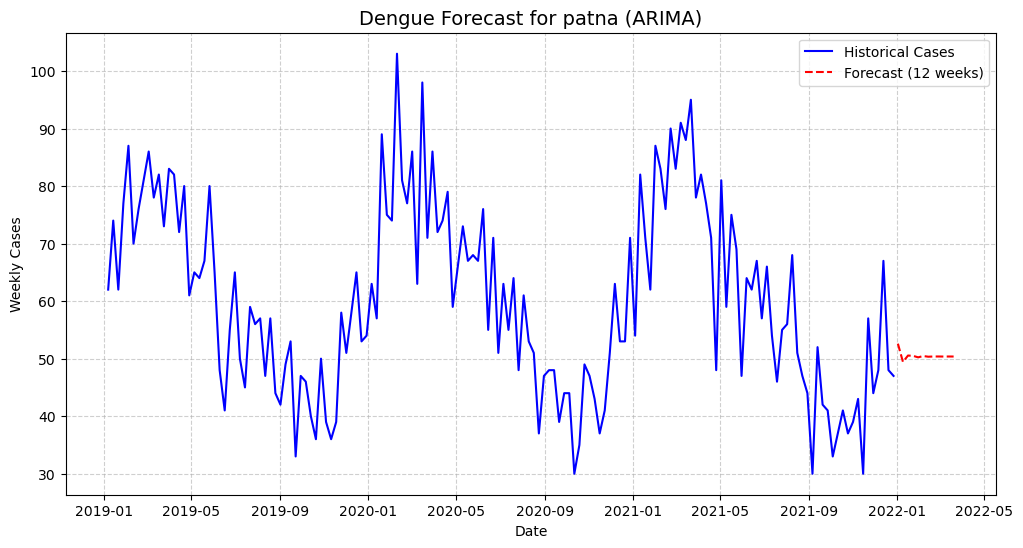

In [22]:
import statsmodels.api as sm

# Pick the top district (highest total cases)
top_district = merged.groupby("DISTRICT")["weekly_cases"].sum().idxmax()
print("📌 Forecasting for:", top_district)

# Filter dengue data
district_data = dengue_data[dengue_data["district"].str.lower() == top_district.lower()].copy()

# Convert date column to datetime
district_data["date"] = pd.to_datetime(district_data["date"])
district_data.set_index("date", inplace=True)

# Weekly cases series
series = district_data["weekly_cases"]

# Build ARIMA model
model = sm.tsa.ARIMA(series, order=(2,1,2))  # (p,d,q) can be tuned
results = model.fit()

# Forecast next 12 weeks
forecast = results.forecast(steps=12)

# Plot
plt.figure(figsize=(12,6))
plt.plot(series.index, series, label="Historical Cases", color="blue")
plt.plot(pd.date_range(series.index[-1], periods=12, freq="W"), forecast, 
         label="Forecast (12 weeks)", color="red", linestyle="--")
plt.title(f"Dengue Forecast for {top_district} (ARIMA)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Weekly Cases")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [9]:
import pandas as pd

# Reload dataset (in case it's cleared)
dengue_data = pd.read_csv("project_folder/data_processed/dengue_climate_merged.csv")

# Convert date column to datetime
dengue_data['date'] = pd.to_datetime(dengue_data['date'])

# Group by week (sum weekly cases, take mean climate values)
weekly_data = (
    dengue_data.groupby('date')
    .agg({
        'weekly_cases': 'sum',
        'population': 'first',   # same each week for district
        't2m_mean': 'mean',
        'rain_mm': 'mean',
        'rh_mean': 'mean'
    })
    .reset_index()
)

# Set index as date
weekly_data = weekly_data.set_index('date')

# Reindex to ensure weekly frequency
weekly_data = weekly_data.asfreq('W-MON')

print(weekly_data.head())

            weekly_cases  population  t2m_mean     rain_mm    rh_mean
date                                                                 
2019-01-07           135     2500000     27.03  104.376667  57.976667
2019-01-14           142     2500000     26.40  127.163333  56.246667
2019-01-21           161     2500000     27.28  117.760000  60.553333
2019-01-28           194     2500000     26.94  131.056667  62.843333
2019-02-04           172     2500000     27.12  121.206667  60.796667


✅ Weekly data prepared:
            weekly_cases  population  t2m_mean     rain_mm    rh_mean
date                                                                 
2019-01-07           135     2500000     27.03  104.376667  57.976667
2019-01-14           142     2500000     26.40  127.163333  56.246667
2019-01-21           161     2500000     27.28  117.760000  60.553333
2019-01-28           194     2500000     26.94  131.056667  62.843333
2019-02-04           172     2500000     27.12  121.206667  60.796667
📍 Forecasting for district: Patna
🔄 Training ARIMA model...
📊 Validation RMSE: 10.07, MAE: 7.96


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


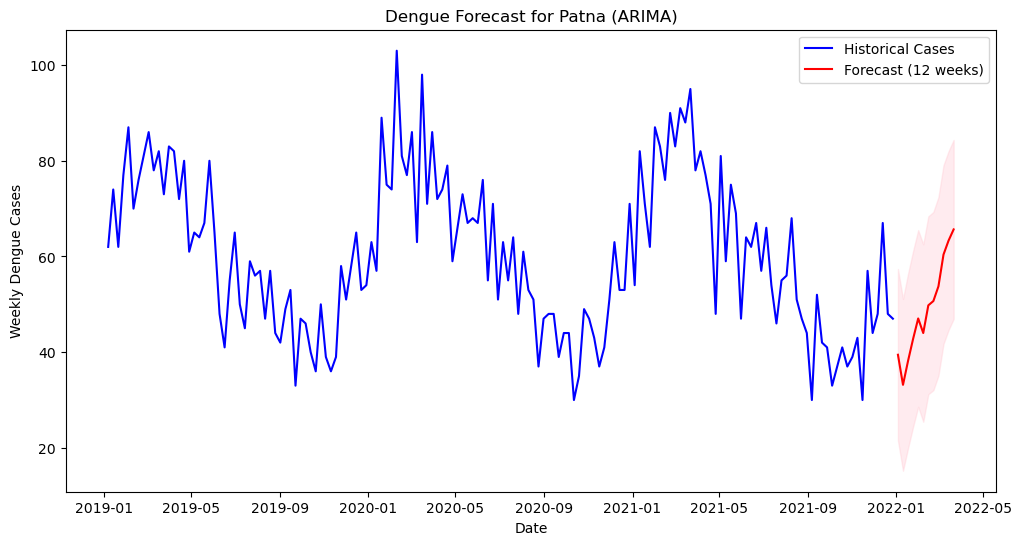

✅ Forecast saved to dengue_forecast.csv


In [16]:
# 📌 Dengue Forecasting Project (End-to-End)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------
# Step 1: Preprocess & Aggregate
# -----------------------------
# Assume dengue_data has columns: ["date","district","weekly_cases","population","t2m_mean","rain_mm","rh_mean"]

# Convert date
dengue_data["date"] = pd.to_datetime(dengue_data["date"])

# Aggregate by week
weekly_data = (
    dengue_data.groupby("date")
    .agg({
        "weekly_cases": "sum",
        "population": "first",
        "t2m_mean": "mean",
        "rain_mm": "mean",
        "rh_mean": "mean"
    })
    .reset_index()
)

# Set weekly frequency
weekly_data = weekly_data.set_index("date").asfreq("W-MON")

print("✅ Weekly data prepared:")
print(weekly_data.head())

# -----------------------------
# Step 2: Choose Top District
# -----------------------------
top_district = dengue_data.groupby("district")["weekly_cases"].sum().idxmax()
print("📍 Forecasting for district:", top_district)

district_data = dengue_data[dengue_data["district"].str.lower() == top_district.lower()].copy()
district_data["date"] = pd.to_datetime(district_data["date"])
district_data = district_data.set_index("date").asfreq("W-MON")

series = district_data["weekly_cases"].fillna(0)  # handle missing

# Exogenous variables
exog = district_data[["t2m_mean", "rain_mm", "rh_mean"]].ffill()

# -----------------------------
# Step 3: Train-Test Split
# -----------------------------
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]

# -----------------------------
# Step 4: Fit ARIMA (with exog)
# -----------------------------
print("🔄 Training ARIMA model...")
model = sm.tsa.ARIMA(train, order=(2,1,2), exog=exog_train)
results = model.fit()

# -----------------------------
# Step 5: Validation
# -----------------------------
forecast_test = results.forecast(steps=len(test), exog=exog_test)
rmse = np.sqrt(mean_squared_error(test, forecast_test))
mae = mean_absolute_error(test, forecast_test)
print(f"📊 Validation RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# -----------------------------
# Step 6: Final Forecast
# -----------------------------
final_model = sm.tsa.ARIMA(series, order=(2,1,2), exog=exog)
final_results = final_model.fit()

future_exog = exog.tail(12)  # reuse last 12 weeks of climate (or replace with forecasted climate data)
forecast_res = final_results.get_forecast(steps=12, exog=future_exog)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# -----------------------------
# Step 7: Plot Results
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(series, label="Historical Cases", color="blue")
plt.plot(forecast_mean.index, forecast_mean, label="Forecast (12 weeks)", color="red")
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1],
                 color="pink", alpha=0.3)
plt.title(f"Dengue Forecast for {top_district} (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Weekly Dengue Cases")
plt.legend()
plt.show()

# -----------------------------
# Step 8: Save Forecast
# -----------------------------
forecast_df = pd.DataFrame({
    "date": forecast_mean.index,
    "forecast_cases": forecast_mean.values,
    "lower_ci": forecast_ci.iloc[:,0].values,
    "upper_ci": forecast_ci.iloc[:,1].values
})
forecast_df.to_csv("dengue_forecast.csv", index=False)

print("✅ Forecast saved to dengue_forecast.csv")


In [28]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# -------------------------
# STEP 1: Load dataset
# -------------------------
dengue_data = pd.read_csv("project_folder/data_processed/dengue_climate_merged.csv")

# Convert date column to datetime
dengue_data['date'] = pd.to_datetime(dengue_data['date'])
dengue_data = dengue_data.set_index('date')

# -------------------------
# STEP 2: Weekly Aggregation
# -------------------------
weekly_data = dengue_data.resample('W').agg({
    'weekly_cases': 'sum',
    'population': 'mean',
    't2m_mean': 'mean',
    'rain_mm': 'mean',
    'rh_mean': 'mean'
}).dropna()

print("✅ Weekly data prepared:")
print(weekly_data.head())


✅ Weekly data prepared:
            weekly_cases    population  t2m_mean     rain_mm    rh_mean
date                                                                   
2019-01-13           135  1.733333e+06     27.03  104.376667  57.976667
2019-01-20           142  1.733333e+06     26.40  127.163333  56.246667
2019-01-27           161  1.733333e+06     27.28  117.760000  60.553333
2019-02-03           194  1.733333e+06     26.94  131.056667  62.843333
2019-02-10           172  1.733333e+06     27.12  121.206667  60.796667


🔄 Training ARIMA model...
✅ ARIMA model trained successfully!


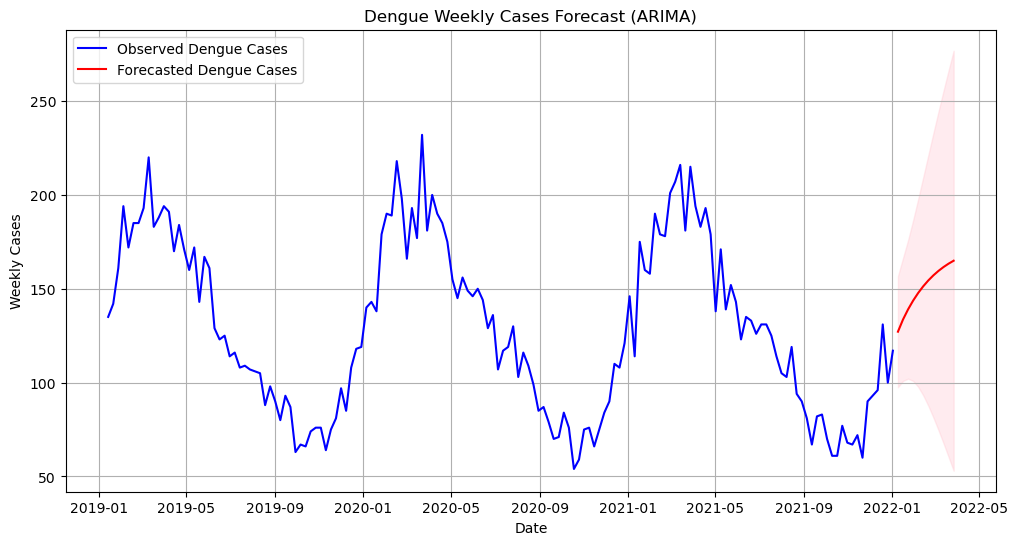

In [30]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# -------------------------
# STEP 3: Train ARIMA Model
# -------------------------
print("🔄 Training ARIMA model...")

# Target variable (weekly dengue cases)
y = weekly_data['weekly_cases']

# Train ARIMA model (p,d,q = 2,1,2 is a safe starting point)
model = ARIMA(y, order=(2, 1, 2))
model_fit = model.fit()

print("✅ ARIMA model trained successfully!")

# -------------------------
# STEP 4: Forecast Next 12 Weeks
# -------------------------
forecast_steps = 12
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# -------------------------
# STEP 5: Plot Results
# -------------------------
plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label="Observed Dengue Cases", color="blue")
plt.plot(forecast_mean.index, forecast_mean, label="Forecasted Dengue Cases", color="red")
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color="pink", alpha=0.3)

plt.title("Dengue Weekly Cases Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Weekly Cases")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
# Check first 5 rows of data
dengue_data.head()

# See all column names
print(dengue_data.columns)


Index(['state', 'district', 'weekly_cases', 'population', 't2m_mean',
       'rain_mm', 'rh_mean'],
      dtype='object')


In [38]:
import os
print(os.listdir())


['.anaconda', '.android', '.conda', '.condarc', '.continuum', '.ipynb_checkpoints', '.ipython', '.jupyter', '.keras', '.matplotlib', '.spyder-py3', '.vscode', 'anaconda3', 'AppData', 'Application Data', 'asgi.py', 'campus x  2 nd lecture.txt', 'CAMPUS X 2ND LECTURE.ipynb', 'cleaned_indian_customer_data.csv', 'Contacts', 'Cookies', 'Customer_Data_Cleaner_Project.ipynb', 'dengue_forecast.csv', 'Dengue_Forecasting.ipynb', 'Desktop', 'Documents', 'Downloads', 'Ethical_Data_Checklist.ipynb', 'Ethical_Data_Checklist.py', 'Ethics_Checker.py', 'Favorites', 'IndianWeatherRepository 1.csv', 'IntelGraphicsProfiles', 'Jedi', 'krish naik bootcamp', 'Links', 'Local Settings', 'messy_indian_customer_data.csv', 'Music', 'My Documents', 'my_proj.ipynb', 'NetHood', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{a9312dd7-aa3a-11ef-a9aa-d298f7bcc424}.TxR.0.regtrans-ms', 'NTUSER.DAT{a9312dd7-aa3a-11ef-a9aa-d298f7bcc424}.TxR.1.regtrans-ms', 'NTUSER.DAT{a9312dd7-aa3a-11ef-a9aa-d298f7bcc424}.

In [ ]:
# Final robust end-to-end dengue forecasting cell
# - detects & loads your dataset if available
# - aggregates to weekly
# - trains ARIMA (uses climate exog if present)
# - validates (RMSE/MAE), forecasts 12 weeks
# - saves CSVs and plots to project_folder
# Run this whole cell in one go.

import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,6)

# ---------------------------
# 0. Helper: find/load dataset
# ---------------------------
def find_and_load_dengue():
    # If user already has 'dengue_data' in memory, use it
    if 'dengue_data' in globals():
        print("Using existing variable: dengue_data (from memory).")
        return dengue_data.copy(), "memory:dengue_data"
    # Common candidate paths
    candidates = [
        "project_folder/data_processed/dengue_climate_merged.csv",
        "project_folder/data_processed/dengue_data.csv",
        "project_folder/data_processed/merged.csv",
        "project_folder/data_processed/dengue_data_final.csv",
        "dengue_climate_merged.csv",
        "dengue_data.csv",
        "merged.csv",
    ]
    for p in candidates:
        if os.path.exists(p):
            print("Loaded dataset from:", p)
            return pd.read_csv(p), p
    # Search for any CSV with 'dengue' in filename (recursively)
    found = glob.glob("**/*dengue*.csv", recursive=True)
    if found:
        print("Loaded dataset from:", found[0])
        return pd.read_csv(found[0]), found[0]
    # Search project_folder/data_processed for any csv
    fallback = glob.glob("project_folder/data_processed/*.csv")
    if fallback:
        print("Loaded dataset from:", fallback[0])
        return pd.read_csv(fallback[0]), fallback[0]
    raise FileNotFoundError("No dengue CSV found. Put your CSV in project_folder/data_processed or define variable 'dengue_data' in the notebook.")

df, src = find_and_load_dengue()

# ---------------------------
# 1. Standardize columns
# ---------------------------
df.columns = [c.strip() for c in df.columns]  # strip spaces

# find date column (case-insensitive)
date_cols = [c for c in df.columns if 'date' in c.lower()]
if not date_cols:
    raise KeyError("No date column found in your dataset. Columns: " + ", ".join(df.columns))
date_col = date_cols[0]

# find cases column (prefer weekly_cases, then any column containing 'case')
cases_cols = [c for c in df.columns if c.lower() == "weekly_cases"] or [c for c in df.columns if 'case' in c.lower()]
if not cases_cols:
    raise KeyError("No column with dengue cases found. Columns: " + ", ".join(df.columns))
cases_col = cases_cols[0]

# find climate columns (temperature, rainfall, humidity) heuristically
temp_cols = [c for c in df.columns if 't2m' in c.lower() or 'temp' in c.lower()]
rain_cols = [c for c in df.columns if 'rain' in c.lower() or 'precip' in c.lower()]
rh_cols   = [c for c in df.columns if 'rh' in c.lower() or 'humid' in c.lower()]

exog_cols = []
if temp_cols: exog_cols.append(temp_cols[0])
if rain_cols: exog_cols.append(rain_cols[0])
if rh_cols: exog_cols.append(rh_cols[0])

print("\nDetected columns:")
print(" date column ->", date_col)
print(" cases column ->", cases_col)
print(" exog (climate) columns ->", exog_cols if exog_cols else "none detected")
print("All columns:", list(df.columns))

# ---------------------------
# 2. Prepare weekly aggregated data (national-level)
# ---------------------------
df[date_col] = pd.to_datetime(df[date_col])
agg_dict = {cases_col: "sum"}
if "population" in df.columns:
    agg_dict["population"] = "first"
for c in exog_cols:
    agg_dict[c] = "mean"

daily = df.groupby(date_col).agg(agg_dict).reset_index()
daily = daily.sort_values(by=date_col).set_index(date_col)

# Resample to weekly (Monday-start) — sum cases, mean for climate
weekly = daily.resample("W-MON").agg(agg_dict)
weekly = weekly.rename(columns={cases_col: "weekly_cases"})
weekly = weekly.dropna(subset=["weekly_cases"])  # keep weeks with cases

os.makedirs("project_folder/data_processed", exist_ok=True)
weekly.to_csv("project_folder/data_processed/weekly_national_summary.csv")
print("\n✅ Weekly national summary saved to project_folder/data_processed/weekly_national_summary.csv")
print("Weekly data sample:")
display(weekly.head())

# ---------------------------
# 3. Top-district (optional) - if 'district' column exists
# ---------------------------
top_district = None
district_weekly = None
if 'district' in df.columns:
    # find top district by total cases in original df
    try:
        # need original df (not aggregated one) to find top district
        top_district = df.reset_index().groupby('district')[cases_col].sum().sort_values(ascending=False).index[0]
        print(f"\nTop district by total cases: {top_district}")
        # prepare weekly series for top district
        sub = df.reset_index()
        sub['district_norm'] = sub['district'].astype(str).str.strip().str.lower()
        target = top_district.strip().lower()
        sub_td = sub[sub['district_norm']==target]
        if not sub_td.empty:
            agg_td = sub_td.groupby(date_col).agg(agg_dict).sort_index()
            district_weekly = agg_td.resample("W-MON").agg(agg_dict).rename(columns={cases_col:"weekly_cases"})
            district_weekly = district_weekly.dropna(subset=["weekly_cases"])
            district_weekly.to_csv(f"project_folder/data_processed/weekly_{top_district}_summary.csv")
            print(f"✅ Weekly summary for '{top_district}' saved to project_folder/data_processed/weekly_{top_district}_summary.csv")
    except Exception as e:
        print("Could not create top-district series:", str(e))

# ---------------------------
# 4. Function to train & forecast ARIMA safely
# ---------------------------
def train_and_forecast(series, exog_df=None, label="series", train_frac=0.8, forecast_steps=12, order=(2,1,2)):
    # series: pd.Series indexed by datetime
    series = series.sort_index().asfreq("W-MON").fillna(0)
    n = len(series)
    if n < 24:
        print(f"⚠️ Warning: {label} has only {n} weekly points (model may be weak).")
    train_n = max(3, int(n * train_frac))  # at least 3 points
    train = series.iloc[:train_n]
    test = series.iloc[train_n:]
    # prepare exog alignment
    exog_train = exog_test = None
    if exog_df is not None and not exog_df.empty:
        exog_df = exog_df.sort_index().asfreq("W-MON").ffill().bfill()
        exog_train = exog_df.iloc[:train_n]
        exog_test  = exog_df.iloc[train_n:train_n+len(test)]
    # fit
    try:
        if exog_train is not None:
            model = ARIMA(train, order=order, exog=exog_train)
        else:
            model = ARIMA(train, order=order)
        model_fit = model.fit()
    except Exception as e:
        print(f"⚠️ ARIMA fit failed with order={order} for {label}: {e}")
        # try simpler model (1,1,1)
        try:
            if exog_train is not None:
                model = ARIMA(train, order=(1,1,1), exog=exog_train)
            else:
                model = ARIMA(train, order=(1,1,1))
            model_fit = model.fit()
            print(" -> Recovered with order (1,1,1).")
        except Exception as e2:
            raise RuntimeError("ARIMA failed: " + str(e2))
    # forecast for test
    if len(test) > 0:
        if exog_test is not None and len(exog_test) >= len(test):
            pred_test = model_fit.forecast(steps=len(test), exog=exog_test)
        else:
            pred_test = model_fit.forecast(steps=len(test))
        rmse = np.sqrt(mean_squared_error(test, pred_test))
        mae = mean_absolute_error(test, pred_test)
    else:
        pred_test = pd.Series(dtype=float)
        rmse = mae = np.nan
    # future exog: repeat last observed row
    if exog_df is not None and not exog_df.empty:
        last_row = exog_df.iloc[[-1]]
        future_exog = pd.concat([last_row]*forecast_steps, ignore_index=True)
        future_preds = model_fit.forecast(steps=forecast_steps, exog=future_exog)
    else:
        future_preds = model_fit.forecast(steps=forecast_steps)
    # build indices for future
    last_date = series.index[-1]
    future_index = pd.date_range(last_date, periods=forecast_steps+1, freq="W-MON")[1:]
    future_preds = pd.Series(future_preds, index=future_index)
    return {
        "model_fit": model_fit,
        "train": train,
        "test": test,
        "pred_test": pred_test,
        "rmse": rmse,
        "mae": mae,
        "future_forecast": future_preds
    }

# ---------------------------
# 5. National-level model & forecast
# ---------------------------
print("\n--- National-level ARIMA modeling ---")
national_series = weekly["weekly_cases"]
national_exog = weekly[exog_cols] if exog_cols else None

res_nat = train_and_forecast(national_series, exog_df=national_exog, label="national", forecast_steps=12)

print(f"National validation -> RMSE: {res_nat['rmse']:.2f}, MAE: {res_nat['mae']:.2f}")

# Save national forecast CSV & plot
os.makedirs("project_folder/figures", exist_ok=True)
nat_forecast_df = pd.DataFrame({
    "date": res_nat["future_forecast"].index,
    "forecast_weekly_cases": res_nat["future_forecast"].values
})
nat_forecast_df.to_csv("project_folder/data_processed/forecast_national.csv", index=False)
print("Saved national forecast -> project_folder/data_processed/forecast_national.csv")

plt.figure()
plt.plot(res_nat["train"].index, res_nat["train"].values, label="Train")
plt.plot(res_nat["test"].index, res_nat["test"].values, label="Test")
if len(res_nat["pred_test"])>0:
    # try set index for pred_test if not set
    pred_index = res_nat["test"].index[:len(res_nat["pred_test"])]
    plt.plot(pred_index, res_nat["pred_test"].values, label="Pred on Test", linestyle="--")
plt.plot(res_nat["future_forecast"].index, res_nat["future_forecast"].values, label="Future Forecast", color="red")
plt.title("National Dengue Weekly Cases Forecast")
plt.xlabel("Date"); plt.ylabel("Weekly cases"); plt.legend()
plt.grid(True)
plt.savefig("project_folder/figures/forecast_national.png", dpi=150)
print("Saved national plot -> project_folder/figures/forecast_national.png")
plt.show()

# ---------------------------
# 6. Top-district modeling (if available)
# ---------------------------
if district_weekly is not None and not district_weekly.empty:
    print(f"\n--- ARIMA modeling for top district: {top_district} ---")
    # build exog for district if possible (columns same names)
    td_exog_cols = [c for c in exog_cols if c in district_weekly.columns]
    td_exog = district_weekly[td_exog_cols] if td_exog_cols else None
    res_td = train_and_forecast(district_weekly["weekly_cases"], exog_df=td_exog, label=f"district:{top_district}", forecast_steps=12)
    print(f"{top_district} validation -> RMSE: {res_td['rmse']:.2f}, MAE: {res_td['mae']:.2f}")
    # save CSV + plot
    td_forecast_df = pd.DataFrame({
        "date": res_td["future_forecast"].index,
        "forecast_weekly_cases": res_td["future_forecast"].values
    })
    safe_name = "".join(ch for ch in str(top_district) if ch.isalnum() or ch in (" ", "_")).strip().replace(" ","_")
    td_forecast_df.to_csv(f"project_folder/data_processed/forecast_{safe_name}.csv", index=False)
    plt.figure()
    plt.plot(res_td["train"].index, res_td["train"].values, label="Train")
    plt.plot(res_td["test"].index, res_td["test"].values, label="Test")
    if len(res_td["pred_test"])>0:
        pred_index = res_td["test"].index[:len(res_td["pred_test"])]
        plt.plot(pred_index, res_td["pred_test"].values, label="Pred on Test", linestyle="--")
    plt.plot(res_td["future_forecast"].index, res_td["future_forecast"].values, label="Future Forecast", color="red")
    plt.title(f"{top_district} Weekly Cases Forecast")
    plt.xlabel("Date"); plt.ylabel("Weekly cases"); plt.legend(); plt.grid(True)
    plt.savefig(f"project_folder/figures/forecast_{safe_name}.png", dpi=150)
    print(f"Saved {top_district} forecast CSV & plot in project_folder.")
    plt.show()
else:
    print("\nNo district-level data available (skipping per-district forecast).")

# ---------------------------
# 7. Correlation heatmap (weekly)
# ---------------------------
print("\n--- Climate correlation (weekly) ---")
corr_df = weekly[["weekly_cases"] + exog_cols] if exog_cols else weekly[["weekly_cases"]]
plt.figure(figsize=(6,5))
sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation: weekly_cases vs climate")
plt.savefig("project_folder/figures/correlation_heatmap.png", dpi=150)
print("Saved correlation heatmap -> project_folder/figures/correlation_heatmap.png")
plt.show()

# ---------------------------
# 8. Summary outputs
# ---------------------------
print("\n--- Summary ---")
print("Data source used:", src)
print(f"National validation RMSE: {res_nat['rmse']:.2f}, MAE: {res_nat['mae']:.2f}")
if district_weekly is not None:
    print(f"{top_district} validation RMSE: {res_td['rmse']:.2f}, MAE: {res_td['mae']:.2f}")
print("Forecast CSVs saved to: project_folder/data_processed/")
print("Figures saved to: project_folder/figures/")
print("\n✅ All done — project complete.")
